In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [2]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
            
            for i in range(3):
                maxVDot[i] = max(abs(float(row[4+i])), maxVDot[i])
                maxAlphaDot[i] = max(abs(float(row[7+i])), maxAlphaDot[i])
        routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
        allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

387047
16.049999237060547 35.887664794921875 1.0 [19.161849975585938, 8.428146362304688, 11.452590942382812] [0.0880889892578125, 0.8147430419921875, 0.1421051025390625]


In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_length),
            nn.Tanh()
        )

        
    def forward(self, x):
        return self.linear_relu_stack(x)

model = torch.load('model_s.pth')
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=270, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
    (5): Tanh()
  )
)


In [46]:
r = routes[0]
r_phi = r.phi
r_v = r.v
r_M = r.M
r_IMU_v = r.IMU_v
r_IMU_alpha = r.IMU_alpha

print(len(r))

groups = [5, 15, 4, 20, 20]

prev_data = 300
fwd_data = [20, 40, 60, 80, 100]
norm = (16.049999237060547, 35.887664794921875, 1.0, [19.161849975585938, 8.428146362304688, 11.452590942382812], [0.0880889892578125, 0.8147430419921875, 0.1421051025390625])

##Defining steps from model_controls

wb = np.load('/home/gregor/openpilot/model_s_keras_weights.npz', allow_pickle=True)
w, b = wb['wb']

def np_model(x):
  x = np.array(x, dtype=np.float32)
  l0 = np.dot(x, w[0]) + b[0]
  l0 = np.maximum(0, l0)
  l1 = np.dot(l0, w[1]) + b[1]
  l1 = np.maximum(0, l1)
  l2 = np.dot(l1, w[2]) + b[2]
  l2 = np.tanh(l2)
  return l2

def get_model_input(phi, v, M, IMU_v, IMU_alpha, M_fut):
  phi_out = phi.reshape(-1, groups[0]).mean(axis=1)/norm[0]
  v_out = v.reshape(-1, groups[1]).mean(axis=1)/norm[1]
  M_out_l = M.reshape(-1, groups[2]).mean(axis=1)/norm[2]
  M_out_r = M_fut.reshape(-1, groups[2]).mean(axis=1)/norm[2]
  M_out = np.concatenate([M_out_l, M_out_r])
  IMU_v_out = [IMU_v[i].reshape(-1, groups[3]).mean(axis=1)/norm[3][i] for i in range(3)]
  IMU_alpha_out = [IMU_alpha[i].reshape(-1, groups[4]).mean(axis=1)/norm[4][i] for i in range(3)]

  return np.concatenate([phi_out, v_out, M_out, IMU_v_out[0], IMU_v_out[1], IMU_v_out[2], IMU_alpha_out[0], IMU_alpha_out[1], IMU_alpha_out[2]])

class ModelControls:
  def __init__(self):
    
    self.phi = np.zeros((prev_data,))
    self.v = np.zeros((prev_data,))
    self.M = np.zeros((prev_data,))
    self.IMU_v = [np.zeros((prev_data,)) for _ in range(3)]
    self.IMU_alpha = [np.zeros((prev_data,)) for _ in range(3)]

    self.active = False #Ensure good init on change
    self.outputTorque = 0 #TODO refactor this variable


  def parse_logs(self, idx):
    phi = r_phi[idx]
    v = r_v[idx]
    M = r_M[idx]
    self.outputTorque = M
    IMU_v = [r_IMU_v[i][idx] for i in range(3)]
    IMU_alpha = [r_IMU_alpha[i][idx] for i in range(3)]
    
    # spravi phi, v, M v numPy array
    self.phi = np.roll(self.phi, -1)
    self.phi[-1]=phi
    self.v = np.roll(self.v, -1)
    self.v[-1]=v
    self.M = np.roll(self.M, -1)
    self.M[-1]=M
    for i in range(3):
      self.IMU_v[i] = np.roll(self.IMU_v[i], -1)
      self.IMU_v[i][-1] = IMU_v[i]
      self.IMU_alpha[i] = np.roll(self.IMU_alpha[i], -1)
      self.IMU_alpha[i][-1] = IMU_alpha[i]
    
  def predict_angle(self):
    #Comments for np/torch comparison
    M_fut = np.ones((fwd_data[-1],))*self.M[-1]
    model_input = get_model_input(self.phi, self.v, self.M, self.IMU_v, self.IMU_alpha, M_fut)
#     model_input_torch = torch.tensor(model_input, dtype=torch.float32)
    predicted_angle = np_model(model_input)
#     predicted_angle2 = model(model_input_torch)
    return predicted_angle
#     return predicted_angle, predicted_angle2



4915


In [185]:
idx = prev_data
model_cont = ModelControls()
for i in range(idx, idx+300):
    model_cont.parse_logs(i)
idx+=300

0.30000001192092896


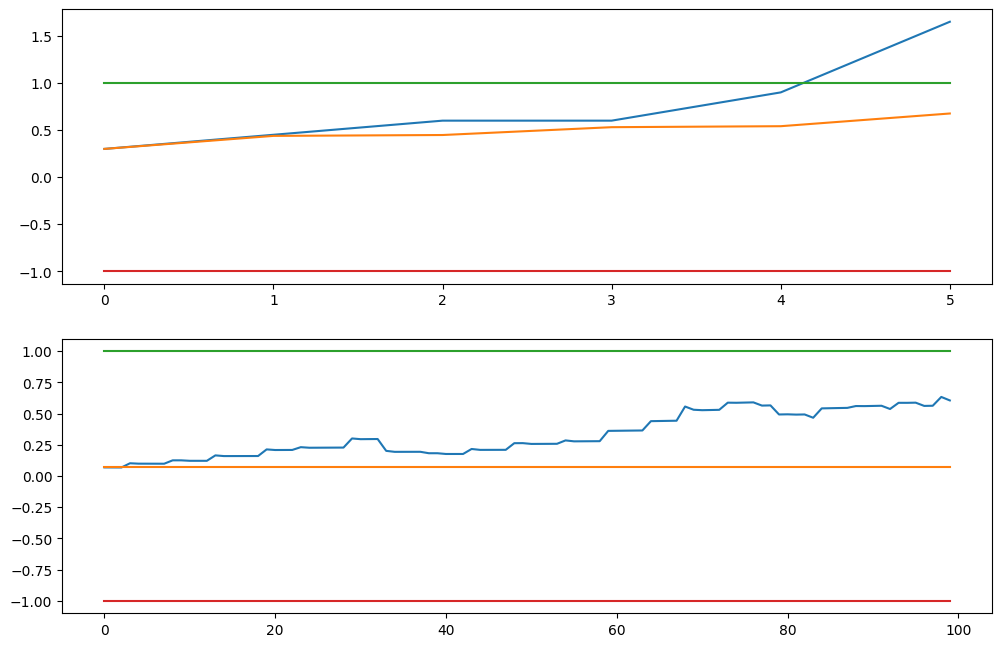

In [420]:
for _ in range(1):
    idx+=1
    initial_angle = r_phi[idx]
    model_cont.parse_logs(idx)
data_output = model_cont.predict_angle()*maxAngle

output_length = len(fwd_data)
M_fut_len = fwd_data[-1]

phi_good = [initial_angle] +[r_phi[idx+fwd_data[i]] for i in range(output_length)]
phi_pred = [initial_angle] +[data_output[i] for i in range(output_length)]

M_imagined = [r_M[idx] for _ in range(M_fut_len)]
M_real = [r_M[idx+i] for i in range(M_fut_len)]

print(r_phi[idx].item())
axs = plt.subplots(2)[1]

axs[0].plot(np.linspace(0, output_length, output_length+1), phi_good)
axs[0].plot(np.linspace(0, output_length, output_length+1), phi_pred)
axs[0].plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*1)
axs[0].plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*-1)

axs[1].plot(np.linspace(0, M_fut_len-1, M_fut_len), M_real)
axs[1].plot(np.linspace(0, M_fut_len-1, M_fut_len), M_imagined)
axs[1].plot(np.linspace(0, M_fut_len-1, M_fut_len), np.ones((M_fut_len,))*1)
axs[1].plot(np.linspace(0, M_fut_len-1, M_fut_len), np.ones((M_fut_len,))*-1)